In [42]:
#import modules
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout, Activation, Flatten
from keras.layers import LSTM, Dense
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('Sub0-RAW.csv')
df.head()

Dates  Year  Month  Day    Hours  Precipitation  Temperature  Outflow
0  10/1/1980  1980     10    1  0:00:00            0.0      102.992      5.0
1  10/1/1980  1980     10    1  1:00:00            0.0       97.790      5.0
2  10/1/1980  1980     10    1  2:00:00            0.0       92.588      5.0
3  10/1/1980  1980     10    1  3:00:00            0.0       87.404      5.0
4  10/1/1980  1980     10    1  4:00:00            0.0       85.172      5.0

In [3]:
train_cols = ["Precipitation","Temperature","Outflow"]

In [4]:
new_df = df.filter(train_cols, axis=1)

In [5]:
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

In [6]:
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

In [7]:
lag_df = lag_seq(new_df, 1)
lag_df.dropna(inplace=True)

In [8]:
lag_df

Precipitation  Temperature  Outflow  Outflow(t+1)
0                 0.0      102.992      5.0           5.0
1                 0.0       97.790      5.0           5.0
2                 0.0       92.588      5.0           5.0
3                 0.0       87.404      5.0           5.0
4                 0.0       85.172      5.0           5.0
...               ...          ...      ...           ...
185538            0.0       52.880     29.0          30.0
185539            0.0       54.284     30.0          29.0
185540            0.0       55.670     29.0          29.0
185541            0.0       57.074     29.0          31.0
185542            0.0       57.056     31.0          38.0

[185543 rows x 4 columns]

In [9]:
#label_cols = ["Outflow(t+1)", "Outflow(t+2)", "Outflow(t+3)"]
label_cols = ["Outflow(t+1)"]

In [12]:
#Min Max scalr normalizing
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [13]:
#Splitting training and test data
df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
x_train = df_train.loc[:,train_cols].values
y_train = df_train.loc[:,label_cols].values
x_test = df_test.loc[:,train_cols].values
y_test = df_test.loc[:,label_cols].values

In [14]:
x_train.shape, y_test.shape

((148434, 3), (37109, 1))

In [15]:
y_train_actual = y_train
y_test_actual = y_test

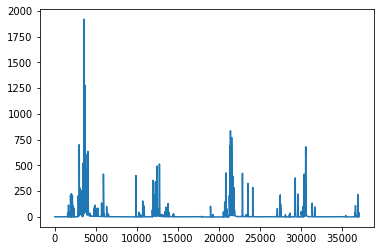

In [16]:
plt.figure()
plt.plot(y_test_actual)
plt.show()

In [17]:
#Normalizing training data
x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

# Normalizing test data
x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
y_test_nor = ytest_min_max_scaler.fit_transform(y_test)

In [18]:
#Building timeseries
X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=18, out_steps=1)
X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=18, out_steps=1)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



length of time-series i/o (148416, 18, 3) (148416,)



length of time-series i/o (37091, 18, 3) (37091,)


In [19]:
X_Train.shape,Y_Train.shape

((148416, 18, 3), (148416,))

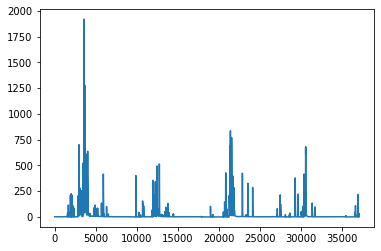

In [20]:
plt.figure()
plt.plot(Y_test_actual)
plt.show()

In [26]:
#Build Model
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, strides=1,
                padding='same',activation='relu', input_shape=
                (X_Train.shape[1], X_Train.shape[2])))
model.add(Conv1D(filters=32, kernel_size=3,strides = 1,
                      padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2), strides = (1,1)))

model.add(Flatten())

model.add(Dense(20, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 18, 64)            640       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 18, 32)            6176      
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                11540     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 18,377
Trainable params: 18,377
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(X_Train, Y_Train, epochs=10,
                   validation_data=(X_Test, Y_Test))

Epoch 1/10
4638/4638 [==============================] - 10s 2ms/step - loss: 2.9384e-05 - val_loss: 4.4742e-05
Epoch 2/10
4638/4638 [==============================] - 13s 3ms/step - loss: 7.7240e-06 - val_loss: 4.7541e-06
Epoch 3/10
4638/4638 [==============================] - 13s 3ms/step - loss: 4.3633e-06 - val_loss: 2.6588e-06
Epoch 4/10
4638/4638 [==============================] - 11s 2ms/step - loss: 3.6671e-06 - val_loss: 2.3893e-06
Epoch 5/10
4638/4638 [==============================] - 13s 3ms/step - loss: 3.3661e-06 - val_loss: 3.8191e-06
Epoch 6/10
4638/4638 [==============================] - 10s 2ms/step - loss: 2.0901e-06 - val_loss: 3.7583e-06
Epoch 7/10
4638/4638 [==============================] - 10s 2ms/step - loss: 1.4555e-06 - val_loss: 1.3538e-06
Epoch 8/10
4638/4638 [==============================] - 10s 2ms/step - loss: 1.5909e-06 - val_loss: 9.9070e-07
Epoch 9/10
4638/4638 [==============================] - 9s 2ms/step - loss: 1.6107e-06 - val_loss: 2.6849e-06
Ep

In [28]:
weights = model.get_weights()

In [29]:
len(weights)

8

In [30]:
[weights[i].shape for i in range(len(weights))]

[(3, 3, 64), (64,), (3, 64, 32), (32,), (576, 20), (20,), (20, 1), (1,)]

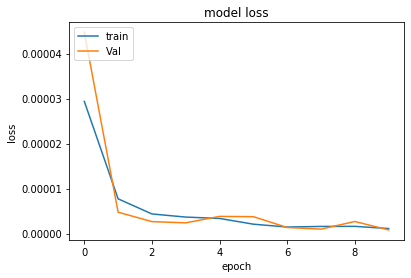

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

In [32]:
#model.save("cnn_model1_waterflow_mse_32.hdf5")

In [33]:
predicted_y_values = model.predict(X_Test)

In [34]:
predicted_y_values_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values)

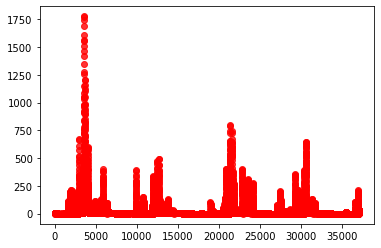

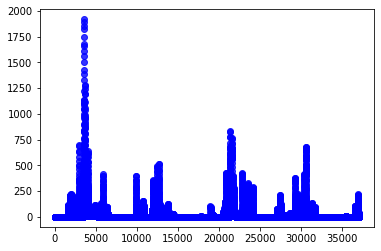

In [35]:
plt.figure()
plt.plot(predicted_y_values_unnor, 'ro', alpha=0.8)
plt.show()
plt.figure()
plt.plot(Y_test_actual, 'bo', alpha=0.8)
plt.show()

In [36]:
max(predicted_y_values_unnor)

array([1779.0078], dtype=float32)

In [37]:
len(Y_test_actual)

37091

In [38]:
len(predicted_y_values_unnor)

37091

In [48]:
y_train_predict = model.predict(X_Train)
predicted_y_train_unnor = ytrain_min_max_scaler.inverse_transform(y_train_predict)

In [40]:
l = len(predicted_y_values_unnor)
acc = sum([np.round(predicted_y_values_unnor[i])==Y_test_actual[i] for i in range(l)])/l
acc

array([0.66749346])

In [43]:
mean_square_root = mean_squared_error(predicted_y_values_unnor, Y_test_actual)
mean_square_root

25.729127544846623

In [44]:
mean_square_root_nor = mean_squared_error(predicted_y_values, Y_Test)
mean_square_root_nor

8.159054858607174e-07

In [45]:
l = len(predicted_y_values)
acc = sum([np.round(predicted_y_values[i])==Y_Test[i] for i in range(l)])/l
acc

array([0.37095252])

In [46]:
# checking mse for test set that are greater than threshold
threshold = 250
timesteps = 18
test_values_above_thres = []
test_labels_above_theres = []

for i in range(timesteps, x_test.shape[0]):
    if (y_test[i] > threshold):
        test_values_above_thres.append(x_test[i-timesteps:i])
        test_labels_above_theres.append(y_test[i]) 
        
X_test_abv_thres = np.array(test_values_above_thres)
Y_test_abv_thres = np.array(test_labels_above_theres)

tsamples, ta, tb = X_test_abv_thres.shape
x_test_for_normalization = X_test_abv_thres.reshape((tsamples,ta*tb)) # since normalization requires 2d array
x_test_for_normalization.shape

X_Test_abv_thres = xtest_min_max_scaler.fit_transform(x_test_for_normalization)
Y_Test_abv_thres = ytest_min_max_scaler.fit_transform(Y_test_abv_thres)

X_Test_abv_thres = X_Test_abv_thres.reshape((tsamples, ta, tb))

In [47]:
predicted_y_test_abv_thres = model.predict(X_Test_abv_thres)
predicted_y_test_abv_thres_unnor = ytest_min_max_scaler.inverse_transform(predicted_y_test_abv_thres)
mean_square_root_abv_thres = mean_squared_error(predicted_y_test_abv_thres, Y_test_abv_thres)
mean_square_root_abv_thres

299536.09243070264

In [49]:
#for model2
#Building timeseries
X_Train1, Y_Train1, Y_train_actual1 = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=19, out_steps=1)
X_Test1, Y_Test1, Y_test_actual1 = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=19, out_steps=1)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



length of time-series i/o (148415, 19, 3) (148415,)



length of time-series i/o (37090, 19, 3) (37090,)


In [50]:
#replacing last value of each timeseries data with the predicted value
len_data = len(X_Train1)

In [51]:
for i in range (len_data):
    X_Train1[i][18][2] = y_train_predict[i][0]

In [57]:
#Build Model for second model
model1 = Sequential()

model1.add(Conv1D(filters=64, kernel_size=3, strides=1,
                padding='same',activation='relu', input_shape=
                (X_Train1.shape[1], X_Train1.shape[2])))
model1.add(Conv1D(filters=32, kernel_size=3,strides = 1,
                      padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2), strides = (1,1)))

model1.add(Flatten())

model1.add(Dense(20, activation='relu'))

model1.add(Dense(1, activation='linear'))

model1.compile(optimizer = 'adam', loss = 'mean_squared_error')

model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 19, 64)            640       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 19, 32)            6176      
_________________________________________________________________
flatten_3 (Flatten)          (None, 608)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                12180     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 19,017
Trainable params: 19,017
Non-trainable params: 0
_________________________________________________________________


In [53]:
predicted_y_values.shape

(37091, 1)

In [54]:
len_data

148415

In [55]:
len_data_test = len(X_Test1)
for i in range (len_data_test):
    X_Test1[i][18][2] = predicted_y_values[i][0]

In [58]:
history = model1.fit(X_Train1, Y_Train1, epochs=10,
                   validation_data=(X_Test1, Y_Test1))

Epoch 1/10
4638/4638 [==============================] - 11s 2ms/step - loss: 5.7330e-05 - val_loss: 1.8572e-05
Epoch 2/10
4638/4638 [==============================] - 13s 3ms/step - loss: 1.5301e-05 - val_loss: 1.1717e-05
Epoch 3/10
4638/4638 [==============================] - 10s 2ms/step - loss: 7.6851e-06 - val_loss: 8.8952e-06
Epoch 4/10
4638/4638 [==============================] - 10s 2ms/step - loss: 6.7076e-06 - val_loss: 7.1944e-06
Epoch 5/10
4638/4638 [==============================] - 10s 2ms/step - loss: 6.0441e-06 - val_loss: 9.6002e-06
Epoch 6/10
4638/4638 [==============================] - 10s 2ms/step - loss: 5.1931e-06 - val_loss: 7.4417e-06
Epoch 7/10
4638/4638 [==============================] - 10s 2ms/step - loss: 4.9786e-06 - val_loss: 1.5889e-05
Epoch 8/10
4638/4638 [==============================] - 11s 2ms/step - loss: 4.4634e-06 - val_loss: 6.7738e-06
Epoch 9/10
4638/4638 [==============================] - 10s 2ms/step - loss: 4.7182e-06 - val_loss: 6.3611e-06
E

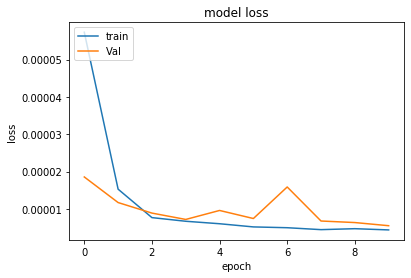

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

In [60]:
predicted_y_values1 = model1.predict(X_Test1)

In [61]:
predicted_y_values1_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values1)

In [62]:
mean_square_root = mean_squared_error(predicted_y_values1_unnor, Y_test_actual1)
mean_square_root

33.345676231105045